# Sistem za klasifikaciju email-ova

## Uvod

   **Klasični pristup (Bag-of-Words + Naive Bayes)**
   - Čišćenje i normalizacija teksta
   - Numerička reprezentacija pomoću BoW
   - Trening jednostavnog Naive Bayes modela
   - Evaluacija modela: Accuracy, Precision, Recall, F1-score, Precision Matrix
   - Opcionalno balansiranje klasa sa SMOTE

## Klasifikaciju pomoću Naive Bayes-a

### Biblioteke

Uvoz potrebnih biblioteka za obradu podataka, metrike, balansiranje klasa i vizualizaciju.

In [1]:
import pandas as pd
import re
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

## Čišćenje i priprema teksta

- **`clean_text`**: normalizuje tekst (mala slova, uklanja "Subject:", linkove, brojeve, specijalne karaktere i višestruke razmake).  
- **`load_datasets`**: učitava Enron i Venky dataset, primenjuje `clean_text` i pretvara label-e u numeričke vrednosti (`0`=ham, `1`=spam).

In [2]:
#formatting text
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"subject:", "", text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text)

    return text.strip()

#preparing dataset
def load_datasets():
    df_enron = pd.read_csv("../../data/enron_mails.csv").dropna(subset=["Message"])
    df_venky = pd.read_csv("../../data/venky_spam_ham_dataset.csv").dropna(subset=["text"])

    df_enron["full_text"] = (
        df_enron["Subject"].fillna("") + " " + df_enron["Message"].fillna("")
    ).apply(clean_text)
    df_venky["text"] = df_venky["text"].apply(clean_text)

    df_enron["label_num"] = df_enron["Spam/Ham"].map({"ham": 0, "spam": 1})
    df_venky["label_num"] = df_venky["label"].map({"ham": 0, "spam": 1})

    return df_enron, df_venky

## Balansiranje klasa sa SMOTE

- **`apply_smote`**: primenjuje SMOTE za balansiranje neuravnoteženih klasa.  
- Prikazuje raspodelu klasa pre i posle oversemplovanja.

In [3]:
def apply_smote(X_bow, y):
    print(f"\nOriginal class distribution: {Counter(y)}")

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_bow, y)

    print(f"Resampled class distribution: {Counter(y_resampled)}")
    return X_resampled, y_resampled

## Bag-of-Words (BoW)

- **`SimpleBoW`**: pretvara tekst u numeričke vektore po principu Bag-of-Words.  
- **`fit`**: kreira rečnik svih reči iz dokumenata.  
- **`transform`**: svaki dokument pretvara u vektor broja pojavljivanja reči.  
- **`fit_transform`**: kombinuje `fit` i `transform` u jednoj funkciji.


In [4]:
class SimpleBoW:
    def __init__(self):
        self.vocab = {}

    def fit(self, documents):
        vocab_set = set()
        for doc in documents:
            for word in doc.split():
                vocab_set.add(word)
        self.vocab = {word: i for i, word in enumerate(sorted(vocab_set))}

    def transform(self, documents):
        n_docs = len(documents)
        n_vocab = len(self.vocab)
        matrix = np.zeros((n_docs, n_vocab), dtype=np.float32)
        for i, doc in enumerate(documents):
            for word in doc.split():
                if word in self.vocab:
                    matrix[i, self.vocab[word]] += 1
        return matrix

    def fit_transform(self, documents):
        self.fit(documents)
        return self.transform(documents)

## Custom Naive Bayes

Ova klasa implementira **Multinomial Naive Bayes** za klasifikaciju teksta (spam/ham).


### 1. Naive Bayes formula

Cilj je odrediti kojoj klasi $(c)$ pripada dokument:

$$
P(c \mid \text{dokument}) = P(c) \times \prod_{i=1}^{n} P(w_i \mid c)^{x_i}
$$

> **Objašnjenje:**  
> - $P(c)$ = prior klase  
> - $P(w_i \mid c)$ = verovatnoća reči $w_i$ u toj klasi  
> - $x_i$ = broj pojavljivanja reči u dokumentu  
> - Verovatnoća klase je proporcionalna prioru klase i proizvodu verovatnoća svih reči u dokumentu


### 2. Laplace smoothing

Dodajemo 1 da izbegnemo verovatnoće 0:

$$
P(w_i \mid c) = \frac{\text{count}(w_i, c) + 1}{\text{ukupan broj reči u klasi} + |V|}
$$

> **Objašnjenje:**  
> - $(|V|)$ = veličina vokabulara  
> - Laplace smoothing osigurava da nijedna reč ne daje verovatnoću 0, što bi uništilo izračunavanje posteriora.


### 3. Logaritmovanje

Proizvod malih verovatnoća može dovesti do **numerical underflow**, pa koristimo log:

$$\log(ab) = \log a + \log b$$

$$
\log P(c \mid \text{dokument}) = \log P(c) + \sum_{i=1}^{n} x_i \log P(w_i \mid c)
$$

> **Objašnjenje:**  
> - Sabiranjem logova dobijamo isti rezultat kao proizvod, ali numerički stabilnije  
> - $(x_i \cdot \log P(w_i \mid c))$ → doprinos svake reči pomnožen sa brojem pojavljivanja  
> - Logaritmom pretvaramo proizvod verovatnoća u sumu, što omogućava “sabiranje dokaza” svake reči za klasu.


### 4. Predikcija

Za svaki dokument računamo log-score po klasama i biramo klasu sa najvećim score-om:

$$
\text{pred} = \arg\max_c \Big( \log P(c) + \sum_{i=1}^{n} x_i \log P(w_i \mid c) \Big)
$$

> **Objašnjenje:**  
> - Rezultat je 0 ili 1 (ham/spam)  
> - Funkcija `max` bira klasu koja je najverovatnija s obzirom na sadržaj dokumenta  
> - Logaritmovanje i sabiranje omogućava da se sabere doprinos svake reči za klasu


In [5]:
class SimpleNaiveBayes:
    def __init__(self):
        self.class_word_probs = {}
        self.class_priors = {}

    def fit(self, X, y):
        n_docs, n_words = X.shape
        classes = np.unique(y)

        for c in classes:
            #getting documents of class
            X_c = X[y == c]
            word_counts = X_c.sum(axis=0)
            total_words = word_counts.sum()

            #laplace smoothing
            probs = (word_counts + 1) / (total_words + n_words) #likelihood of word appearing in class
            self.class_word_probs[c] = probs
            self.class_priors[c] = X_c.shape[0] / n_docs    #likelihood of being that class

    def predict(self, X):
        results = []
        #for document
        for x in X:
            scores = {}
            #for each class
            for c in self.class_word_probs:
                log_prob = np.log(self.class_priors[c])
                log_prob += np.sum(x * np.log(self.class_word_probs[c]))
                scores[c] = log_prob
            pred = max(scores, key=scores.get)
            results.append(pred)
        return np.array(results)

## Funkcije za treniranje i evaluaciju modela

Ovaj deo koda omogućava treniranje Naive Bayes modela na tekstualnim dataset-ovima i evaluaciju njegovih performansi.


### Funkcija `evaluate_model`

- Prima stvarne vrednosti `y_true` i predikcije modela `y_pred`.
- Računa **standardne metrike klasifikacije**:  
  - **Accuracy** – udeo tačno klasifikovanih primera  
  - **Precision** – koliko su pozitivne predikcije tačne  
  - **Recall** – koliko stvarnih pozitivnih primera model pravilno detektuje  
  - **F1-score** – harmonijska sredina precision i recall  
- Prikazuje **confusion matrix** radi vizualnog uvida u greške i tačne klasifikacije.


### Funkcija `train_and_evaluate`

- Omogućava dva režima treniranja:  
  1. **Cross-dataset (`cross`)** – trenira se na Enron ili Venky i testira na drugom dataset-u  
  2. **Split (`split`)** – standardna podela 80/20 unutar Enron dataset-a  
- Koristi **Bag-of-Words** za transformaciju teksta u numerički format.  
- Opcionalno primenjuje **SMOTE** za balansiranje klasa.  
- Trening i predikcija se rade preko `SimpleNaiveBayes` klase.  
- Rezultati se evaluiraju pomoću funkcije `evaluate_model`, koja prikazuje metrike i matricu konfuzije.

In [6]:
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("\nConfusion matrix:")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

def train_and_evaluate(train_enron=1, use_smote=False, mode="cross"):
    df_enron, df_venky = load_datasets()

    if mode == "cross":
        if train_enron == 1:
            X_train = df_enron["full_text"]
            y_train = df_enron["label_num"].to_numpy()
            X_test = df_venky["text"]
            y_test = df_venky["label_num"].to_numpy()
            print("\nTraining on Enron, Testing on Venky")
        else:
            X_train = df_venky["text"]
            y_train = df_venky["label_num"].to_numpy()
            X_test = df_enron["full_text"]
            y_test = df_enron["label_num"].to_numpy()
            print("\nTraining on Venky, Testing on Enron")

    elif mode == "split":
        from sklearn.model_selection import train_test_split
        #enron 80/20 split
        X_train, X_test, y_train, y_test = train_test_split(
            df_enron["full_text"], df_enron["label_num"].to_numpy(),
            test_size=0.2, random_state=42, stratify=df_enron["label_num"]
        )
        print("\nTraining on 80% and testing on 20% of Enron")
    else:
        raise ValueError("mode must be 'cross' or 'split'")

    bow = SimpleBoW()
    X_train_bow = bow.fit_transform(X_train)
    X_test_bow = bow.transform(X_test)

    if use_smote:
        X_train_bow, y_train = apply_smote(X_train_bow, y_train)

    nb = SimpleNaiveBayes()
    nb.fit(X_train_bow, y_train)

    y_pred = nb.predict(X_test_bow)
    evaluate_model(y_test, y_pred)

## Zaključak i pokretanje glavnog dela koda

Kroz ove tri konfiguracije možemo uporediti kako Naive Bayes model radi u različitim scenarijima i uticaj SMOTE balansiranja na rezultate.

Cross WITHOUT SMOTE

Training on Venky, Testing on Enron
Accuracy:  0.9665
Precision: 0.9612
Recall:    0.9677
F1-score:  0.9644

Confusion matrix:
[[15246   547]
 [  452 13534]]


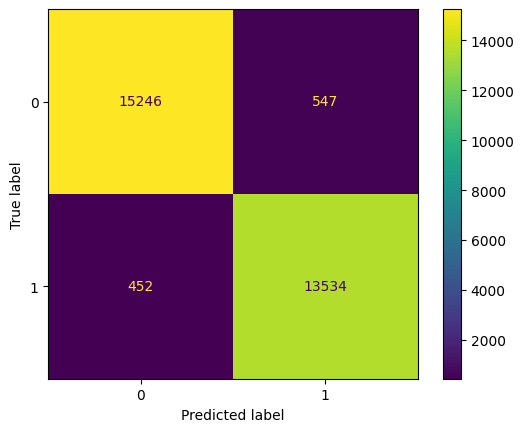


Cross WITH SMOTE
Standard WITHOUT SMOTE

Training on 80% and testing on 20% of Enron
Accuracy:  0.9874
Precision: 0.9864
Recall:    0.9868
F1-score:  0.9866

Confusion matrix:
[[3121   38]
 [  37 2760]]


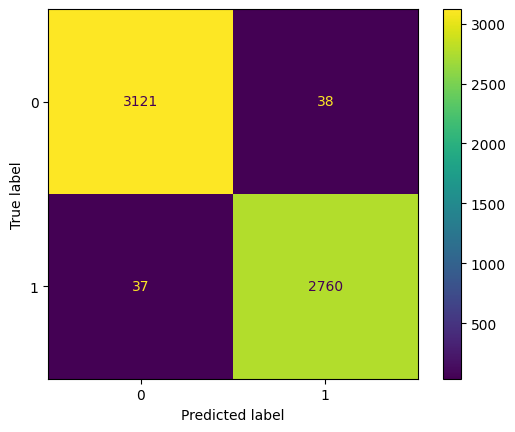

In [8]:
if __name__ == "__main__":
    print("=" * 50)
    print("Cross WITHOUT SMOTE")
    print("=" * 50)
    train_and_evaluate(train_enron=0, use_smote=False)

    print("\n" + "=" * 50)
    print("Cross WITH SMOTE")
    print("=" * 50)
    #train_and_evaluate(train_enron=0, use_smote=True)

    print("=" * 50)
    print("Standard WITHOUT SMOTE")
    print("=" * 50)
    train_and_evaluate(train_enron=0, use_smote=False, mode="split")